# Proyecto de Deep Learning: Análisis de señales de alta frecuencia en aplicaciones industriales

## Viridiana Méndez, Geraldine González

Este proyecto toma como base el artículo de Zhang, Zhizheng & Song, Wen & Li, Qiqiang. (2021) titulado `Dual Aspect Self-Attention based on Transformer for Remaining Useful Life Prediction`.

Se realiza la réplica del paper, para después utilizar los datos de PRONOSTIA sobre rodamientos y estimar el RUL.

Conexión con Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/DL/Proyecto

/content/drive/MyDrive/DL/Proyecto


## Librerías a utilizar

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

import os
import scipy
from scipy.stats import entropy
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model

from DAST_Network import *
from DAST_utils import *

import scipy.io as sio
import time

from torch import nn, optim
from torch.autograd import Variable

import h5py
import fnmatch
import csv

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Réplica de los resultados del artículo con los datos de motores tipo TURBOFAN

Primero se realiza la réplica del paper en el que se utilizan datos C-MAPSS referentes a motores tipo TURBOFAN. El procesamiento de los datos realizó ejecutando los archivos .py proporcionados en el  [GitHub](https://github.com/Zzzsdu/DAST) oficial del artículo.

In [ ]:
RUL_F001 = np.loadtxt('CMAPSSData/RUL_FD001.txt')
train_F001 = np.loadtxt('CMAPSSData/train_FD001.txt')
test_F001 = np.loadtxt('CMAPSSData/test_FD001.txt')

## Características estadísticas

En esta parte se ejecutan algunas líneas se explora un poco el procedimiento que siguen para realizar la extracción de características estadísticas.

Las características extraidas son coeficientes de regresión y el promedio sobre la dimensión del sensor. Las siguientes funciones fueron tomadas del archivo `Statistical features process .py` encontrado en el GitHub.

In [ ]:
regr = linear_model.LinearRegression()  # feature of linear coefficient

def fea_extract1(data):  # feature 1
    fea = []
    x = np.array(range(data.shape[0]))
    for i in range(data.shape[1]):
        regr.fit(x.reshape(-1, 1), np.ravel(data[:, i]))
        fea = fea + list(regr.coef_)
    return fea

def fea_extract2(data):  # feature 2
    fea = []
    for i in range(data.shape[1]):
        fea.append(np.mean(data[:, i]))
    return fea

In [ ]:
trainX = sio.loadmat('F001_window_size_trainX.mat')  #upload sliding time window processed data
trainX = trainX['train1X']
testX =  sio.loadmat('F001_window_size_testX.mat')  #upload sliding time window processed data
testX = testX['test1X']
trainX_fea1 = []
testX_fea1 = []
trainX_fea2 = []
testX_fea2 = []
window_size = 40

In [ ]:
x = np.array(range(data_temp.shape[0]))
data_temp = trainX[0]
print(np.ravel(data_temp[:, 0]).shape)
print(x.reshape(-1, 1).shape)
regr.fit(x.reshape(-1, 1), np.ravel(data_temp[:, 0]))
print(regr.coef_)


(40,)
(40, 1)
[0.00011359]


Gráfica de la regresión obtenida.


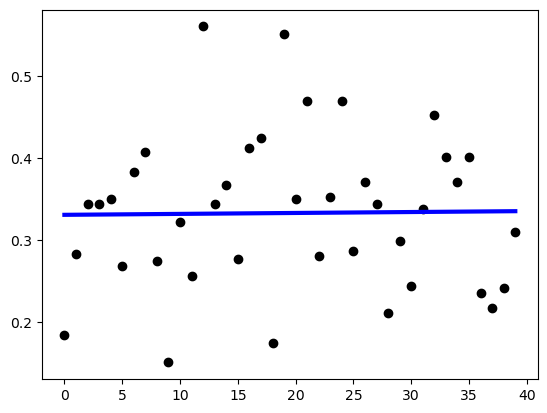

In [ ]:
# Plot outputs
plt.scatter(x.reshape(-1, 1), data_temp[:, 0], color="black")
plt.plot(x.reshape(-1, 1),regr.predict(x.reshape(-1, 1)), color="blue", linewidth=3)
plt.show()

En las siguientes líneas se agregan las características a los datos ya procesados obteniendo ventanas temporales de tamaño 40.

In [ ]:
for i in range(len(trainX)):
    data_temp = trainX[i]
    trainX_fea1.append(fea_extract1(data_temp))
    trainX_fea2.append(fea_extract2(data_temp))

print(len(trainX_fea1))

16731


In [ ]:
np.array(trainX_fea1).shape

(16731, 14)

In [ ]:
trainX_new = []
testX_new = []
Feasize = 14#window_size

for i in range(len(trainX)):
    data_temp0 = trainX[i]
    data_temp1 = np.reshape(trainX_fea1[i], [1, Feasize, 1])  # regr.coef_
    data_temp2 = np.reshape(trainX_fea2[i], [1, Feasize, 1])  # mean_value
    print(data_temp0.shape)
    print(data_temp1.shape)
    print(data_temp2.shape)
    data_temp = np.vstack((data_temp0, data_temp1[0].T, data_temp2[0].T))
    trainX_new.append(data_temp)
trainX_new = np.array(trainX_new)

In [ ]:
trainX_new.shape

(16731, 42, 14)

Después de realizar el pre-procesamiento de los datos, se cargan los archivos obtenidos.

In [ ]:
trainX_= sio.loadmat('F001_window_size_trainX.mat')  #upload sliding time window processed data
testX_ = sio.loadmat('F001_window_size_testX.mat')

In [ ]:
#trainX_new= sio.loadmat('F001_window_size_trainX_new.mat')  #upload sliding time window processed data
testX_new = sio.loadmat('F001_window_size_testX_new.mat')

In [ ]:
#trainY_new= sio.loadmat('F001_window_size_trainY.mat')  #upload sliding time window processed data
testY_new = sio.loadmat('F001_window_size_testY.mat')

Durante el preprocesamiento los datos se guardan en archivos .mat los cuales están definidos como diccionarios, a continuación se extraen los datos de las claves correspondientes.

In [ ]:
#trainY_new = trainY_new['train1Y']
testY_new = testY_new['test1Y']

In [ ]:
#trainX_new = trainX_new['train1X_new']
testX_new = testX_new['test1X_new']

In [ ]:
print(trainX_new.shape, testX_new.shape)

(16731, 42, 14) (100, 42, 14)


In [ ]:
trainY_new.shape

(1, 16731)

Los datos de entrenamiento y prueba así como sus etiquetas se convierten en tensores usando torch.

In [ ]:
trainX_new_ = torch.from_numpy(trainX_new)
trainY_new_ = torch.from_numpy(trainY_new.T)

In [ ]:
trainY_new_.size()

torch.Size([16731, 1])

In [ ]:
testX_new_ = torch.from_numpy(testX_new)
testY_new_ = torch.from_numpy(testY_new.T)

Posteriormente se convierte a Variable de torch y se construye el Tensor Dataset de prueba y de entrenamiento.

In [ ]:
X_train = Variable(torch.Tensor(trainX_new).float())
Y_train = Variable(torch.Tensor(trainY_new.T).float())

In [ ]:
X_test = Variable(torch.Tensor(testX_new).float())
Y_test = Variable(torch.Tensor(testY_new.T).float())

In [ ]:
#train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

Se utiliza un tamaño de batch de 256, un learning rate de 1e-2 y 100 épocas, esto hiperparámetros fueron proporcionados en el paper.

In [ ]:
#Inicializamos los parámetros
batch_size = 256
lr = 1e-2
n_epochs = 10

Se crean los DataLoader de entrenamiento y de prueba.

In [ ]:
args={}
kwargs={}

args['batch_size'] = batch_size
args['test_batch_size'] = batch_size

#train_loader = torch.utils.data.DataLoader(train_dataset,
#                                           batch_size = args['batch_size'],
#                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size = args['test_batch_size'],
                                          shuffle=True)

In [ ]:
len(train_loader)

66

Aunque se hará uso de cpu se realiza la asignación de device.

In [ ]:
device = 'cpu' #if torch.cuda.is_available() else 'cpu'

n_cudas = torch.cuda.device_count()
for i in range(n_cudas):
    print(torch.cuda.get_device_name(i))

Los siguientes hiperparámetros algunos son proporcionados en el artículo y otros fueron encontrados en el GitHub del artículo.

In [ ]:
dim_val_s= 64
dim_attn_s= 64

dim_val_t = 64
dim_attn_t = 64

dim_val = 64
dim_attn = 64

time_step= 42
input_size = 14#batch_size

dec_seq_len = 4
out_seq_len = 1

n_encoder_layers = 2
n_decoder_layers = 1

dropout = 0.2
n_heads = 4

max_rul = 125

Se prosigue a realizar el entrenamiento del modelo.

In [ ]:
#Modelo DAST
model = DAST(dim_val_s=dim_val_s, dim_attn_s= dim_attn_s, dim_val_t=dim_val_t, dim_attn_t=dim_attn_t,
             dim_val = dim_val, dim_attn= dim_attn, time_step = time_step, input_size = input_size,dec_seq_len=dec_seq_len,
             out_seq_len=out_seq_len, n_decoder_layers=n_decoder_layers, n_encoder_layers=n_encoder_layers,
             n_heads=n_heads, dropout=dropout).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

64


In [ ]:
losses = []
val_losses = []

loss_values = []
val_losses = []

# Training loop
for epoch in range(n_epochs):
    # Uses loader to fetch one mini-batch for training
    train_loss = 0.
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.float().to(device)
        yhat = model(x_batch)

        #loss_fn.requires_grad = True
        loss_ = torch.sqrt(criterion(yhat*max_rul,y_batch*max_rul))
        loss_.backward()
        optimizer.step()

        train_loss += loss_.item()

    losses = train_loss/len(train_loader)
    loss_values.append(losses)
    print(f'Época [{epoch+1}/{n_epochs}], Loss: {losses:.4f}')

64
Época [1/10], Loss: 24.7183
Época [2/10], Loss: 14.2533
Época [3/10], Loss: 15.6994
Época [4/10], Loss: 12.8754
Época [5/10], Loss: 13.5759
Época [6/10], Loss: 13.0638
Época [7/10], Loss: 13.5798
Época [8/10], Loss: 12.7906
Época [9/10], Loss: 12.7659
Época [10/10], Loss: 12.5017


# Modelo pre-entrenado

En el Github del artículo se encuentra el modelo

In [ ]:
model = torch.load('F001_DAST_prediciton_model_11.40')

In [ ]:
def myScore(Target, Pred):
    tmp1 = 0
    tmp2 = 0
    for i in range(len(Target)):
        if Target[i] > Pred[i]:
            tmp1 = tmp1 + math.exp((-Pred[i] + Target[i]) / 13.0) - 1
        else:
            tmp2 = tmp2 + math.exp((Pred[i] - Target[i]) / 10.0) - 1
    tmp = tmp1 + tmp2
    return tmp

In [ ]:
Y_test_numpy = Y_test.detach().numpy()
test_list = []

for k ,(batch_x,batch_y) in enumerate(test_loader):
    prediction = model(batch_x)
    prediction[prediction<0] = 0
    test_list.append(prediction)

test_all =  torch.cat(test_list).detach().numpy()
test_all_tensor = torch.from_numpy(test_all)
test_loss = torch.sqrt(criterion(test_all_tensor*125, Y_test*125))
test_score = myScore(Y_test_numpy*125, test_all*125)
print('test_loss = ', test_loss.item(),
          'test_score = ', test_score)

test_loss =  55.56287384033203 test_score =  219524.69737032268


In [ ]:
test_list

[tensor([[0.2566],
         [0.8466],
         [0.2575],
         [0.8179],
         [0.1810],
         [0.7712],
         [0.1220],
         [0.4748],
         [0.8230],
         [0.5519],
         [0.0285],
         [0.7631],
         [0.4442],
         [0.1689],
         [0.7197],
         [0.7733],
         [0.7917],
         [0.1778],
         [0.8385],
         [0.1108],
         [0.1757],
         [0.4766],
         [0.9280],
         [0.7180],
         [0.7622],
         [0.9101],
         [0.7064],
         [0.4380],
         [0.6421],
         [0.9709],
         [0.4746],
         [0.4205],
         [0.7527],
         [0.9093],
         [0.9344],
         [0.8673],
         [0.7470],
         [0.2845],
         [0.7031],
         [0.1170],
         [0.8018],
         [0.2193],
         [0.9434],
         [0.9383],
         [0.4451],
         [0.8588],
         [0.0909],
         [0.8390],
         [0.2001],
         [0.6639],
         [0.5527],
         [0.6946],
         [0.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  # Uses loader to fetch one mini-batch for validation
  #labels_ = []
  predicted_ = []
  count = 0
  for x_batch, y_batch in test_loader:
    #model.eval()
    # Makes predictions
    yhat = model(x_batch)
    yhat[yhat<0] = 0
    predicted_.append(yhat)
    #print(y_batch,predicted)
    #labels_.append(labels)
    count = count + 1

In [ ]:
predicted_

[tensor([[0.9123],
         [0.8385],
         [0.6380],
         [0.0631],
         [0.1980],
         [0.1170],
         [0.9144],
         [0.8647],
         [0.2566],
         [0.8509],
         [0.9280],
         [0.7917],
         [0.4748],
         [0.9434],
         [0.7527],
         [0.9532],
         [0.4089],
         [0.8890],
         [0.3908],
         [0.7064],
         [0.2575],
         [0.4746],
         [0.9632],
         [1.0081],
         [0.9337],
         [0.2001],
         [0.9714],
         [0.4451],
         [0.1689],
         [0.9709],
         [0.9344],
         [0.2414],
         [0.8179],
         [0.9710],
         [0.4766],
         [0.9383],
         [0.1108],
         [0.2136],
         [0.1778],
         [0.4205],
         [0.7209],
         [0.6383],
         [0.1757],
         [0.9079],
         [0.7733],
         [0.1029],
         [0.7197],
         [0.7712],
         [0.9064],
         [0.7948],
         [0.7622],
         [0.2035],
         [0.

In [ ]:
testY_new[0]

array([0.896, 0.784, 0.552, 0.656, 0.728, 0.744, 0.728, 0.76 , 0.888,
       0.768, 0.776, 0.992, 0.76 , 0.856, 0.664, 0.672, 0.4  , 0.224,
       0.696, 0.128, 0.456, 0.888, 0.904, 0.16 , 1.   , 0.952, 0.528,
       0.776, 0.72 , 0.92 , 0.064, 0.384, 0.848, 0.056, 0.088, 0.152,
       0.168, 0.4  , 1.   , 0.224, 0.144, 0.08 , 0.472, 0.872, 0.912,
       0.376, 1.   , 0.736, 0.168, 0.632, 0.912, 0.232, 0.208, 0.776,
       1.   , 0.12 , 0.824, 0.296, 0.912, 0.8  , 0.168, 0.432, 0.576,
       0.224, 1.   , 0.112, 0.616, 0.064, 0.968, 0.752, 0.944, 0.4  ,
       1.   , 1.   , 0.904, 0.08 , 0.272, 0.856, 0.504, 0.72 , 0.064,
       0.072, 1.   , 0.464, 0.944, 0.712, 0.928, 0.92 , 1.   , 0.224,
       0.304, 0.16 , 0.68 , 0.44 , 1.   , 1.   , 0.656, 0.472, 0.936,
       0.16 ])

In [ ]:
pred

array([[0.91234946],
       [0.83847755],
       [0.6379597 ],
       [0.06314805],
       [0.19798473],
       [0.11697643],
       [0.9144005 ],
       [0.8646675 ],
       [0.25664935],
       [0.85086083],
       [0.9280095 ],
       [0.79168713],
       [0.4747782 ],
       [0.9433573 ],
       [0.7526704 ],
       [0.9531605 ],
       [0.4089137 ],
       [0.8889519 ],
       [0.39076802],
       [0.706375  ],
       [0.25753954],
       [0.4745997 ],
       [0.96320367],
       [1.0081084 ],
       [0.93370837],
       [0.20008051],
       [0.9714495 ],
       [0.44509202],
       [0.16890545],
       [0.9708916 ],
       [0.93437165],
       [0.24137595],
       [0.81791115],
       [0.9710214 ],
       [0.47661892],
       [0.9383242 ],
       [0.11084563],
       [0.21355405],
       [0.17784625],
       [0.4205385 ],
       [0.7208595 ],
       [0.63827837],
       [0.17565995],
       [0.90786403],
       [0.7733314 ],
       [0.10286601],
       [0.71971536],
       [0.771

In [ ]:
pred = predicted_[0].detach().numpy()
pred.shape

(100, 1)

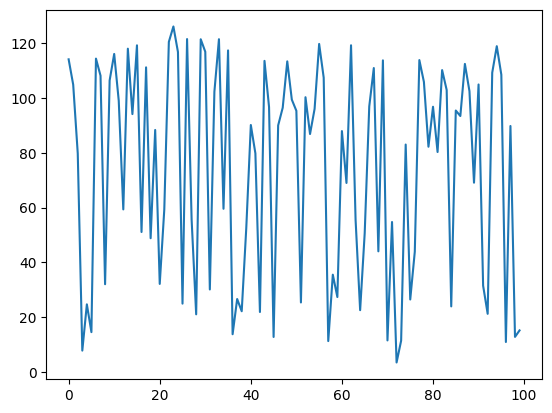

In [ ]:
plt.plot(pred*125)
plt.plot()

# Procedimiento con Bearings

El primer paso es unir todos los archivos:

In [ ]:
#Folder train set
folder1_1 = "FEMTOBearingDataSet/Learning_set/Bearing1_1/"
folder2_1 = "FEMTOBearingDataSet/Learning_set/Bearing2_1/"
folder3_1 = "FEMTOBearingDataSet/Learning_set/Bearing3_1/"
folder1_2 = "FEMTOBearingDataSet/Learning_set/Bearing1_2/"
folder2_2 = "FEMTOBearingDataSet/Learning_set/Bearing2_2/"
folder3_2 = "FEMTOBearingDataSet/Learning_set/Bearing3_2/"

In [ ]:
#Folder test set
folder1_3 = "FEMTOBearingDataSet/Test_set/Bearing1_3/"
folder1_4 = "FEMTOBearingDataSet/Test_set/Bearing1_4/"
folder1_5 = "FEMTOBearingDataSet/Test_set/Bearing1_5/"
folder1_6 = "FEMTOBearingDataSet/Test_set/Bearing1_6/"
folder1_7 = "FEMTOBearingDataSet/Test_set/Bearing1_7/"

In [ ]:
def unir(folder):
    #Archivos del primer conjunto de datos
    files_1st = os.listdir(folder)
    df = pd.read_csv(folder+ files_1st[0], header=None)
    for f in files_1st:
        if fnmatch.fnmatch(f, f"acc*.csv"):
            df1 = pd.read_csv(folder+ f, header=None)
            df = np.append(df,df1.values,0)
    return df

In [ ]:
bearing1_1 = unir(folder1_1)

In [ ]:
bearing1_1.shape

(7178240, 6)

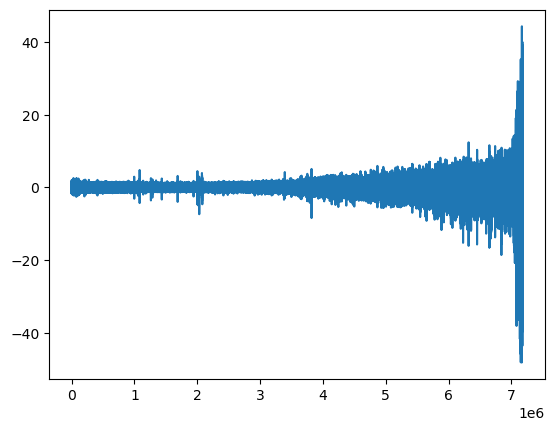

In [ ]:
plt.plot(bearing1_1[:,4])
plt.show()

In [ ]:
bearing2_1 = unir(folder2_1)
bearing3_1 = unir(folder3_1)

In [ ]:
bearing1_2 = unir(folder1_2)

In [ ]:
bearing1_1.shape[0]

7178240

In [ ]:
sio.savemat('bearing1_1.mat', {"bearing1_1": bearing1_1})
sio.savemat('bearing2_1.mat', {"bearing2_1": bearing2_1})
sio.savemat('bearing3_1.mat', {"bearing3_1": bearing3_1})
sio.savemat('bearing1_2.mat', {"bearing1_2": bearing1_2})

In [ ]:
#Unir test
bearing1_3 = unir(folder1_3)
bearing1_4 = unir(folder1_4)
bearing1_5 = unir(folder1_5)
bearing1_6 = unir(folder1_6)
bearing1_7 = unir(folder1_7)

In [ ]:
sio.savemat('bearing1_3.mat', {"bearing1_3": bearing1_3})
sio.savemat('bearing1_4.mat', {"bearing1_4": bearing1_4})
sio.savemat('bearing1_5.mat', {"bearing1_5": bearing1_5})
sio.savemat('bearing1_6.mat', {"bearing1_6": bearing1_6})
sio.savemat('bearing1_7.mat', {"bearing1_7": bearing1_7})

In [ ]:
bearing1_1 = sio.loadmat('bearing1_1.mat')  #upload sliding time window processed data
bearing1_1 = bearing1_1['bearing1_1']
bearing1_2 = sio.loadmat('bearing1_2.mat')  #upload sliding time window processed data
bearing1_2 = bearing1_2['bearing1_2']
bearing1_3 = sio.loadmat('bearing1_3.mat')  #upload sliding time window processed data
bearing1_3 = bearing1_3['bearing1_3']
bearing1_4 = sio.loadmat('bearing1_4.mat')  #upload sliding time window processed data
bearing1_4 = bearing1_4['bearing1_4']
bearing1_5 = sio.loadmat('bearing1_5.mat')  #upload sliding time window processed data
bearing1_5 = bearing1_5['bearing1_5']
bearing1_6 = sio.loadmat('bearing1_6.mat')  #upload sliding time window processed data
bearing1_6 = bearing1_6['bearing1_6']
bearing1_7 = sio.loadmat('bearing1_7.mat')  #upload sliding time window processed data
bearing1_7 = bearing1_7['bearing1_7']


In [ ]:
bearing1_1.shape

(7178240, 6)

Para crear las etiquetas del RUL se considera el FTP para cada Bearing, los cuales están dados por, que es el tiempo en segundos hasta que empieza a modificarse el estado del rodamiento.

In [ ]:
FTPB_1 = 11420
FTPB_2 = 8220
FTPB_3 = 9600
FTPB_4 = 101180
FTPB_5 = 24070
FTPB_6 = 16270
FTPB_7 = 22040

In [ ]:
def Y_rul(FTP, len_):
    seg = len_/256 #Total de segundos
    rul = np.ones(len_) # RUL con 1's
    len1 = len_*FTP/seg #Saber el indice a partir del cual se modifica el estado del rodamiento
    x = np.arange(len1,len_)
    rul_=1/(len1-len_)*x-len_/(len1-len_)

    rul[int(len1):]=rul_

    return rul

In [ ]:
Y_bearing1 = Y_rul(FTPB_1,bearing1_1.shape[0])
Y_bearing2 = Y_rul(FTPB_2,bearing1_2.shape[0])
Y_bearing3 = Y_rul(FTPB_3,bearing1_3.shape[0])
Y_bearing4 = Y_rul(FTPB_3,bearing1_3.shape[0])
Y_bearing5 = Y_rul(FTPB_5,bearing1_5.shape[0])
Y_bearing6 = Y_rul(FTPB_6,bearing1_6.shape[0])
Y_bearing7 = Y_rul(FTPB_7,bearing1_7.shape[0])

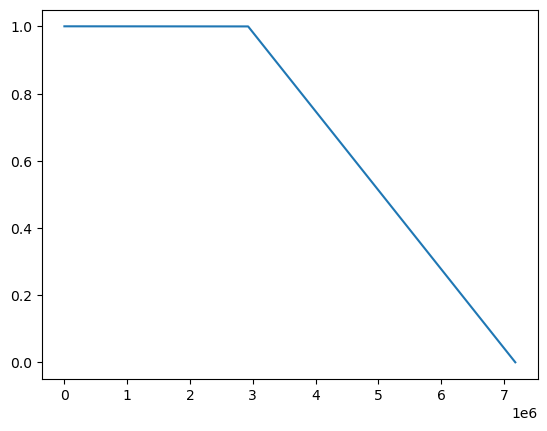

In [ ]:
plt.plot(Y_bearing1)

plt.show()

## Preprocesamiento de los datos

Primero se crea normalizan los datos y se crean las ventanas deslizantes.


In [ ]:
def get_data(files,label_rul, window_Size = 90):
    # The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
    sc = MinMaxScaler()
    data = sc.fit_transform(files)

    trainX = []
    trainY = []

    data_temp = data
    for j in range(len(data_temp) - window_Size + 1):
        trainX.append(data_temp[j:j + window_Size,:].tolist())
        trainY.append(label_rul[j])

    return np.array(trainX), np.array(trainY)

In [ ]:
X_train1_2, Y_train1_2 = get_data(bearing1_2[:,4:6], Y_bearing2, window_Size= 30)

In [ ]:
X_train1_1, Y_train1_1 = get_data(bearing1_1[:,4:6], Y_bearing1, window_Size= 30)

In [ ]:
sio.savemat('Xtrain_bearing1_2.mat', {"Xtrain_bearing1_2": X_train1_2})
sio.savemat('Ytrain_bearing1_2.mat', {"Ytrain_bearing1_2": Y_train1_2})

In [ ]:
sio.savemat('Xtrain_bearing1_1.mat', {"Xtrain_bearing1_1": X_train1_1})
sio.savemat('Ytrain_bearing1_1.mat', {"Ytrain_bearing1_1": Y_train1_1})

Datos para test

In [ ]:
X_test1_3, Y_test1_3 = get_data(bearing1_3[:,4:6], Y_bearing3, window_Size= 30)
X_test1_4, Y_test1_4 = get_data(bearing1_4[:,4:6], Y_bearing4, window_Size= 30)
X_test1_5, Y_test1_5 = get_data(bearing1_5[:,4:6], Y_bearing5, window_Size= 30)
X_test1_6, Y_test1_6 = get_data(bearing1_6[:,4:6], Y_bearing6, window_Size= 30)
X_test1_7, Y_test1_7 = get_data(bearing1_7[:,4:6], Y_bearing7, window_Size= 30)

In [ ]:
sio.savemat('Xtest_bearing1_3.mat', {"Xtest_bearing1_3": X_test1_3})
sio.savemat('Ytest_bearing1_3.mat', {"Ytest_bearing1_3": Y_test1_3})
sio.savemat('Xtest_bearing1_4.mat', {"Xtest_bearing1_4": X_test1_4})
sio.savemat('Ytest_bearing1_4.mat', {"Ytest_bearing1_4": Y_test1_4})
sio.savemat('Xtest_bearing1_5.mat', {"Xtest_bearing1_5": X_test1_5})
sio.savemat('Ytest_bearing1_5.mat', {"Ytest_bearing1_5": Y_test1_5})
sio.savemat('Xtest_bearing1_6.mat', {"Xtest_bearing1_6": X_test1_6})
sio.savemat('Ytest_bearing1_6.mat', {"Ytest_bearing1_6": Y_test1_6})
sio.savemat('Xtest_bearing1_7.mat', {"Xtest_bearing1_7": X_test1_7})
sio.savemat('Ytest_bearing1_7.mat', {"Ytest_bearing1_7": Y_test1_7})

Se prosigue con la extracción de características estadísticas.

In [ ]:
regr = linear_model.LinearRegression()  # feature of linear coefficient

def fea_extract1(data):  # feature 1
    fea = []
    x = np.array(range(data.shape[0]))
    for i in range(data.shape[1]):
        regr.fit(x.reshape(-1, 1), np.ravel(data[:, i]))
        fea = fea + list(regr.coef_)
    return fea

def fea_extract2(data):  # feature 2
    fea = []
    for i in range(data.shape[1]):
        fea.append(np.mean(data[:, i]))
    return fea

In [ ]:
def feat_st(trainX):
    trainX_fea1 = []
    testX_fea1 = []
    trainX_fea2 = []
    testX_fea2 = []
    window_size = 30

    for i in range(len(trainX)):
        data_temp = trainX[i]
        trainX_fea1.append(fea_extract1(data_temp))
        trainX_fea2.append(fea_extract2(data_temp))

    scale1 = MinMaxScaler().fit(trainX_fea1)#归一化
    trainX_fea1 = scale1.transform(trainX_fea1)

    trainX_new = []
    testX_new = []
    Feasize = 2 #window_size

    for i in range(len(trainX)):
        data_temp0 = trainX[i]
        data_temp1 = np.reshape(trainX_fea1[i], [1, Feasize, 1])  # regr.coef_
        data_temp2 = np.reshape(trainX_fea2[i], [1, Feasize, 1])  # mean_value
        data_temp = np.vstack((data_temp0, data_temp1[0].T, data_temp2[0].T))
        trainX_new.append(data_temp)
    trainX_new = np.array(trainX_new)

    return trainX_new

In [ ]:
trainX1_2 = sio.loadmat('Xtrain_bearing1_2.mat')  #upload sliding time window processed data
trainX1_2 = trainX1_2['Xtrain_bearing1_2']

In [ ]:
trainX1_2_new = feat_st(trainX1_2)

In [ ]:
trainX1_2_new.shape

(3, 32, 2)

In [ ]:
sio.savemat('Xtrain_new_bearing1_2.mat', {"trainX1_2_new": trainX1_2_new})

In [ ]:
trainX1_1 = sio.loadmat('Xtrain_bearing1_1.mat')  #upload sliding time window processed data
trainX1_1 = trainX1_1['Xtrain_bearing1_1']

In [ ]:
trainX1_1_new = feat_st(trainX1_1)

In [ ]:
sio.savemat('Xtrain_new_bearing1_1.mat', {"trainX1_1_new": trainX1_1_new})

In [ ]:
testX1_3 = sio.loadmat('Xtest_bearing1_3.mat')  #upload sliding time window processed data
testX1_3 = testX1_3['Xtest_bearing1_3']
testX1_4 = sio.loadmat('Xtest_bearing1_4.mat')  #upload sliding time window processed data
testX1_4 = testX1_4['Xtest_bearing1_4']
testX1_5 = sio.loadmat('Xtest_bearing1_5.mat')  #upload sliding time window processed data
testX1_5 = testX1_5['Xtest_bearing1_5']
testX1_6 = sio.loadmat('Xtest_bearing1_6.mat')  #upload sliding time window processed data
testX1_6 = testX1_6['Xtest_bearing1_6']
testX1_7 = sio.loadmat('Xtest_bearing1_7.mat')  #upload sliding time window processed data
testX1_7 = testX1_7['Xtest_bearing1_7']

In [ ]:
testX1_7.shape

(3847651, 30, 2)

In [ ]:
#testX1_3_new = feat_st(testX1_3)
sio.savemat('Xtest_new_bearing1_3.mat', {"testX1_3_new": testX1_3_new})
testX1_4_new = feat_st(testX1_4)
sio.savemat('Xtest_new_bearing1_4.mat', {"testX1_4_new": testX1_4_new})
testX1_5_new = feat_st(testX1_5)
sio.savemat('Xtest_new_bearing1_5.mat', {"testX1_5_new": testX1_5_new})
testX1_6_new = feat_st(testX1_6)
sio.savemat('Xtest_new_bearing1_6.mat', {"testX1_6_new": testX1_6_new})
testX1_7_new = feat_st(testX1_7)
sio.savemat('Xtest_new_bearing1_7.mat', {"testX1_7_new": testX1_7_new})

In [ ]:
testX1_4_new = feat_st(testX1_4)
sio.savemat('Xtest_new_bearing1_4.mat', {"testX1_4_new": testX1_4_new})

# Entrenamiento

In [ ]:
ls

 B1_DAST_prediciton_model           mi_array.h5                         Xtrain_bearing1_6.mat
 bearing1_1.mat                     Proyecto.ipynb                      Xtrain_bearing1_7.mat
 bearing1_2.mat                     Proyecto_main.py                    Xtrain_new_bearing1_1.mat
 bearing1_3.mat                     __pycache__/                        Xtrain_new_bearing11.mat
 bearing1_4.mat                    'Statistical features process .py'   Xtrain_new_bearing1_2.mat
 bearing1_5.mat                     trainX1_2_new.h5                    Ytest_bearing1_3.mat
 bearing1_6.mat                     Xtest_bearing1_3.mat                Ytest_bearing1_4.mat
 bearing1_7.mat                     Xtest_bearing1_4.mat                Ytest_bearing1_5.mat
 bearing2_1.mat                     Xtest_bearing1_5.mat                Ytest_bearing1_6.mat
 bearing3_1.mat                     Xtest_bearing1_6.mat                Ytest_bearing1_7.mat
 DAST_main.py                       Xtest_bearing1_7.m

In [ ]:
trainX1_1_new = sio.loadmat('Xtrain_new_bearing1_1.mat')  #upload sliding time window processed data
trainX1_1_new = trainX1_1_new['trainX1_1_new']

In [ ]:
trainY1_2_new = sio.loadmat('Ytrain_bearing1_2.mat')
trainY1_2_new = trainY1_2_new['Ytrain_bearing1_2']
trainY1_1_new = sio.loadmat('Ytrain_bearing1_1.mat')
trainY1_1_new = trainY1_1_new['Ytrain_bearing1_1']

In [ ]:
trainX_ = np.concatenate((trainX1_1_new, trainX1_2_new), axis=0)

In [ ]:
trainY1_1_new.shape

(1, 7178211)

In [ ]:
trainY_ = np.concatenate((trainY1_1_new, trainY1_2_new), axis=1)

In [ ]:
trainY_.shape

(1, 9410502)

In [ ]:
X_train = Variable(torch.Tensor(trainX_).float())
Y_train = Variable(torch.Tensor(trainY_.T).float())

In [ ]:
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)

In [ ]:
batch_size = 256
lr = 1e-2
n_epochs = 3

In [ ]:
args={}
kwargs={}

args['batch_size'] = batch_size
args['test_batch_size'] = batch_size

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = args['batch_size'],
                                           shuffle=True)

NameError: ignored

In [ ]:
device = 'cpu' #if torch.cuda.is_available() else 'cpu'

n_cudas = torch.cuda.device_count()
for i in range(n_cudas):
    print(torch.cuda.get_device_name(i))

Tesla T4


In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
dim_val_s= 64
dim_attn_s= 64

dim_val_t = 64
dim_attn_t = 64

dim_val = 64
dim_attn = 64

time_step= 32
input_size = 2#batch_size

dec_seq_len = 4
out_seq_len = 1

n_encoder_layers = 2
n_decoder_layers = 1

dropout = 0.2
n_heads = 4

In [ ]:
#Modelo DAST
model_bearing = DAST(dim_val_s=dim_val_s, dim_attn_s= dim_attn_s, dim_val_t=dim_val_t, dim_attn_t=dim_attn_t,
             dim_val = dim_val, dim_attn= dim_attn, time_step = time_step, input_size = input_size,dec_seq_len=dec_seq_len,
             out_seq_len=out_seq_len, n_decoder_layers=n_decoder_layers, n_encoder_layers=n_encoder_layers,
             n_heads=n_heads, dropout=dropout).to(device)

optimizer = optim.Adam(model_bearing.parameters(), lr=lr)
criterion = nn.MSELoss()

losses = []
val_losses = []

loss_values = []
val_losses = []

# Training loop
for epoch in range(n_epochs):
    # Uses loader to fetch one mini-batch for training
    train_loss = 0.
    model_bearing.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        x_batch = x_batch.to('cpu')
        y_batch = y_batch.to('cpu')
        yhat = model_bearing(x_batch)

        #loss_fn.requires_grad = True
        loss_ = torch.sqrt(criterion(yhat,y_batch))
        loss_.backward()
        optimizer.step()

        train_loss += loss_.item()

    losses = train_loss/len(train_loader)
    loss_values.append(losses)
    print(f'Época [{epoch+1}/{n_epochs}], Loss: {losses:.4f}')

    #Model save
    File_Path = '..' + '\\' + 'DAST' + '\\' + 'B1' + '\\'
    if not os.path.exists(File_Path):
        os.makedirs(File_Path)
    torch.save(model_bearing, File_Path + '/' + 'B1_DAST_prediciton_model')

64


# Prueba

In [ ]:
testX1_4 = sio.loadmat('Xtest_new_bearing1_4.mat')  #upload sliding time window processed data
testX1_4 = testX1_4['testX1_4_new']

In [ ]:
total = testX1_4.shape[0]
ind = 2800000

In [ ]:
testY1_4 = sio.loadmat('Ytest_bearing1_4.mat')
testY1_4 = testY1_4['Ytest_bearing1_4']

In [ ]:
testX1_4.shape

(2918371, 32, 2)

In [ ]:
testY1_4[0][ind:total].shape

(118371,)

In [ ]:
testX1_4= testX1_4[ind:total,:,:]
testY1_4 = testY1_4[0][ind:total]

In [ ]:
testX1_4.shape

(418371, 32, 2)

In [ ]:
X_test = Variable(torch.Tensor(testX1_4).float())
Y_test = Variable(torch.Tensor(testY1_4).float())

In [ ]:
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

In [ ]:
args={}
kwargs={}

args['batch_size'] = batch_size
args['test_batch_size'] = batch_size


In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size = args['test_batch_size'],
                                          shuffle=True)

In [ ]:
device = 'cpu' if torch.cuda.is_available() else 'cpu'

n_cudas = torch.cuda.device_count()
for i in range(n_cudas):
    print(torch.cuda.get_device_name(i))

Tesla T4


In [ ]:
#Modelo DAST
model_bearing = DAST(dim_val_s=dim_val_s, dim_attn_s= dim_attn_s, dim_val_t=dim_val_t, dim_attn_t=dim_attn_t,
             dim_val = dim_val, dim_attn= dim_attn, time_step = time_step, input_size = input_size,dec_seq_len=dec_seq_len,
             out_seq_len=out_seq_len, n_decoder_layers=n_decoder_layers, n_encoder_layers=n_encoder_layers,
             n_heads=n_heads, dropout=dropout).to(device)

64


In [ ]:
model_bearing = torch.load('B1_DAST_prediciton_model')

In [ ]:
Y_test_numpy = Y_test.detach().numpy()
test_list = []

for k ,(batch_x,batch_y) in enumerate(test_loader):
    prediction = model_bearing(batch_x.to(device)).to(device)
    prediction[prediction<0] = 0
    test_list.append(prediction)

test_all =  torch.cat(test_list).detach().numpy()
test_all_tensor = torch.from_numpy(test_all)
test_loss = torch.sqrt(criterion(test_all_tensor*125, Y_test*125))
test_score = myScore(Y_test_numpy*125, test_all*125)
print('test_loss = ', test_loss.item(),
          'test_score = ', test_score)

In [ ]:
model_bearing = torch.load('B1_DAST_prediciton_model')
Y_test_numpy = Y_test.detach().numpy()
test_list = []

for k ,(batch_x,batch_y) in enumerate(test_loader):
    prediction = model_bearing(batch_x)
    prediction[prediction<0] = 0
    test_list.append(prediction)
    #test_loss = torch.sqrt(criterion(prediction*125, batch_y*125))
    #prediction_numpy = prediction.detach().numpy()
    #batch_y_numpy = batch_y.detach().numpy()
    #test_score = myScore(batch_y_numpy*125, prediction_numpy*125)

test_all =  torch.cat(test_list).detach().numpy()
test_all_tensor = torch.from_numpy(test_all)
test_loss = torch.sqrt(criterion(test_all_tensor*125, Y_test*125))
test_score = myScore(Y_test_numpy*125, test_all*125)
print('test_loss = ', test_loss.item(),
          'test_score = ', test_score)